In [246]:
import torch
import torch.nn.functional as F
from torch import nn
from torchvision.io import read_image
from torch.utils.data import Dataset

### Customizing the data to fit PyTorch DataLoader

In [268]:
batch_size = 4

In [338]:
import pandas as pd

data = pd.read_csv('train.csv', sep=",", header=None)
test = torch.tensor(list(data.iloc[0, 6:-1].astype('float')))
print(torch.reshape(test, (16, 8)))

test2 = data[1]
#print(list(test2))

le = preprocessing.LabelEncoder()
test3 = le.fit_transform(test2)
#print(list(test3))

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 1., 1., 1., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0., 1., 1., 0.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [60]:
test = data[data[5]==9]
val_list = [7, 8]
val = data[data[5].isin(val_list)]
train = data[data[5] < 7]

train.to_csv('train.csv', index=False, header=False)
test.to_csv('test.csv', index=False, header=False)
val.to_csv('val.csv', index=False, header=False)

In [16]:
data[1].iloc[1]

'm'

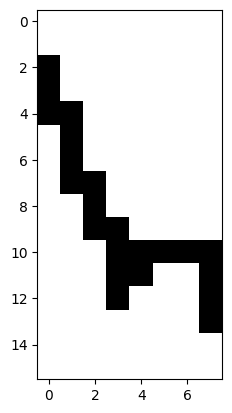

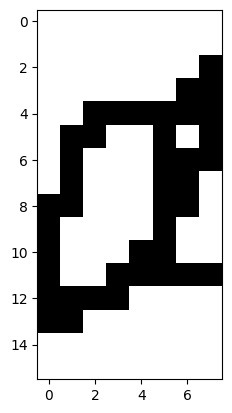

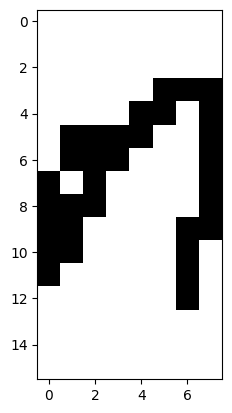

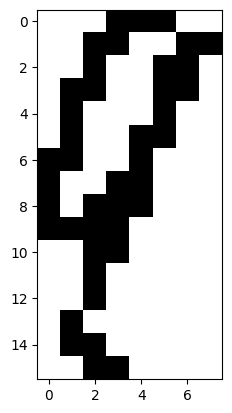

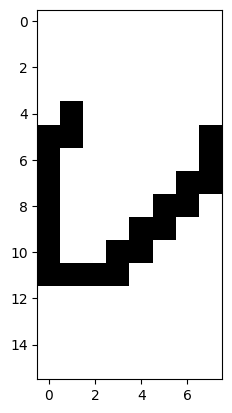

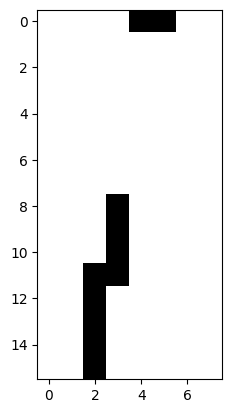

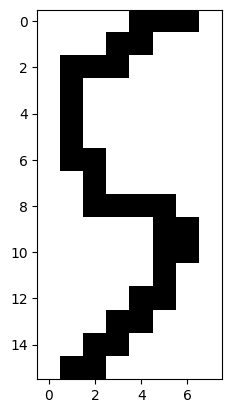

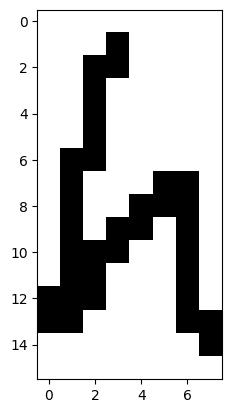

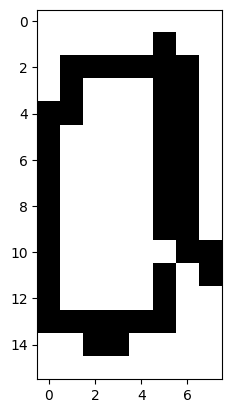

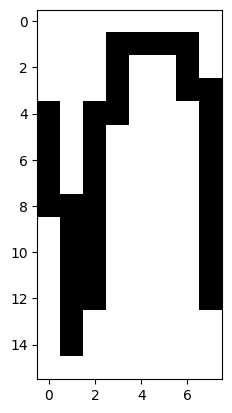

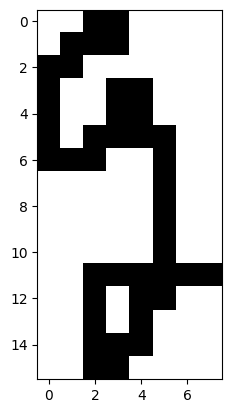

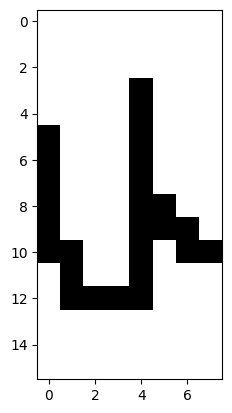

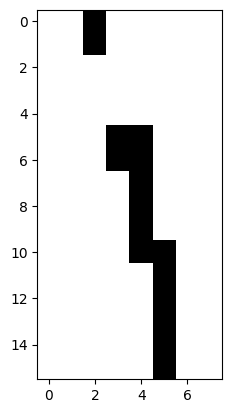

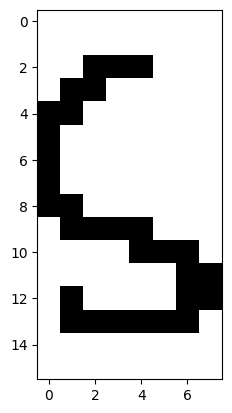

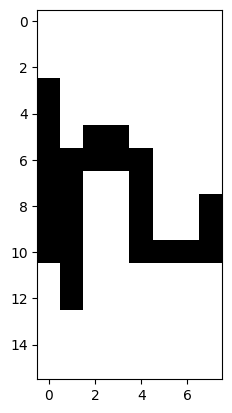

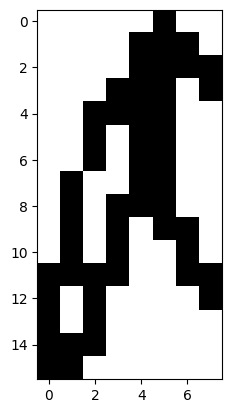

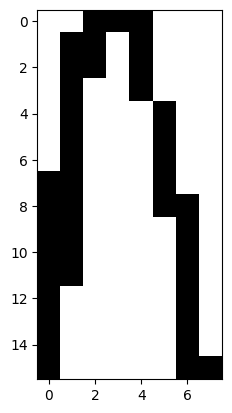

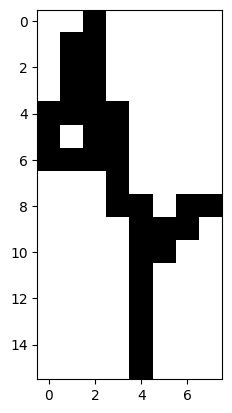

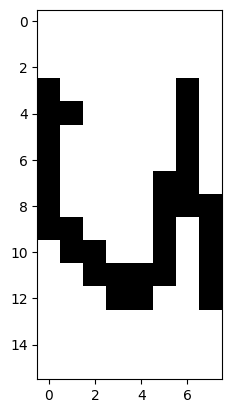

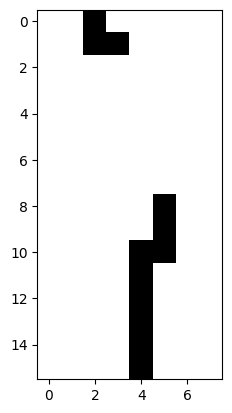

In [8]:
import matplotlib.pyplot as plt

for tests in range(10000, 10020):
    image = list(data.iloc[tests])

    image = image[6:]

    X = []
    for i in range(16):
        X.append([])
        for j in range(8):
            if(image[i*8+j] != None):
                X[i].append(image[(i*8)+j])

    im = plt.imshow(X, cmap='Greys')
    plt.show()

In [277]:
from sklearn import preprocessing
import torch

#Another preprocessing step required

class CustomImageDataset(Dataset):
    le = preprocessing.LabelEncoder()
    
    def __init__(self, annotations_file, transform=None, target_transform=None):
        self.img_file = pd.read_csv(annotations_file, sep=",", header=None) #Customized for .data file
        self.img_labels = self.img_file[1]
        self.img_labels = list(le.fit_transform(list(self.img_labels)))
        #self.img_dir = img_dir #Can be redacted
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        #####################################################################
        #                                                                   #
        #img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])#
        #image = read_image(img_path)                                       #
        #                                                                   #
        ###### No longer required as images are in .data file ###############
        image = torch.tensor(list(self.img_file.iloc[idx, 6:-1].astype('float')))
        image = torch.reshape(image, (1, 16, 8))
        label = self.img_labels
        label = torch.as_tensor(label)[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [301]:
from torch.utils.data import DataLoader

training_data = CustomImageDataset('train.csv')
test_data = CustomImageDataset('test.csv')
validation_data = CustomImageDataset('val.csv')

training_loader = torch.utils.data.DataLoader(training_data, batch_size=4, shuffle=True)
testing_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)

Feature batch shape: torch.Size([4, 1, 16, 8])
Labels batch shape: torch.Size([4])


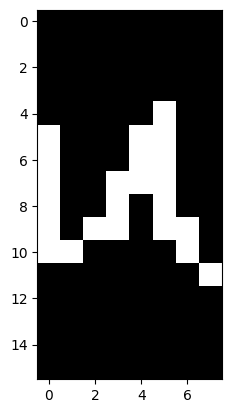

Label: 20


In [288]:
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### Training Model

In [238]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [299]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, padding=1)
        
        self.fc1 = torch.nn.Linear(512, 26)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        #print('x_shape:', x.shape)
        x = x.view(-1, self.num_flat_features(x))
        x = F.dropout(x)
        x = F.relu(self.fc1(x))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
model = Model().to(device)

In [295]:
print(model)

Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=26, bias=True)
)


### Testing the model

In [346]:
test5 = torch.rand(1, 1, 16, 8, device=device)
log = model(test5)
pred_probab = nn.Softmax(dim=1)(log)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([6])


### Loss function

In [200]:
loss_fn = torch.nn.CrossEntropyLoss()

#Just an example to check the calculation from cross entropy loss
#################################################################
dummy_outputs = torch.rand(4, 10)

dummy_labels = torch.tensor([1,5,3,7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))
#################################################################

tensor([[0.0790, 0.2369, 0.6891, 0.1000, 0.4643, 0.5624, 0.2188, 0.5709, 0.2831,
         0.3671],
        [0.9094, 0.9909, 0.8051, 0.7199, 0.2096, 0.4967, 0.1766, 0.9571, 0.1201,
         0.1705],
        [0.4384, 0.7345, 0.3195, 0.2396, 0.0847, 0.7828, 0.9917, 0.0158, 0.8489,
         0.0868],
        [0.6111, 0.8604, 0.7355, 0.1587, 0.7021, 0.2219, 0.1262, 0.1242, 0.6384,
         0.1202]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.5216190814971924


### Optimizer

In [201]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Full Implementation (https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)

In [292]:
print(len(training_loader))

9078


In [313]:
len(training_loader.dataset)

36309

In [311]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [358]:
learning_rate = 0.002

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(training_loader, model, loss_fn, optimizer)
    test_loop(testing_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.257585  [    4/36309]
loss: 0.362611  [  404/36309]
loss: 1.475559  [  804/36309]
loss: 0.129617  [ 1204/36309]
loss: 0.017313  [ 1604/36309]
loss: 1.930734  [ 2004/36309]
loss: 2.002095  [ 2404/36309]
loss: 0.274389  [ 2804/36309]
loss: 0.305998  [ 3204/36309]
loss: 0.292848  [ 3604/36309]
loss: 0.404428  [ 4004/36309]
loss: 0.510249  [ 4404/36309]
loss: 0.037267  [ 4804/36309]
loss: 0.308068  [ 5204/36309]
loss: 0.631679  [ 5604/36309]
loss: 0.069956  [ 6004/36309]
loss: 0.277958  [ 6404/36309]
loss: 1.081774  [ 6804/36309]
loss: 1.177554  [ 7204/36309]
loss: 0.085650  [ 7604/36309]
loss: 0.660649  [ 8004/36309]
loss: 0.317133  [ 8404/36309]
loss: 0.024990  [ 8804/36309]
loss: 0.070266  [ 9204/36309]
loss: 0.042641  [ 9604/36309]
loss: 0.232456  [10004/36309]
loss: 0.317576  [10404/36309]
loss: 0.181211  [10804/36309]
loss: 0.098095  [11204/36309]
loss: 0.151170  [11604/36309]
loss: 0.108986  [12004/36309]
loss: 0.549933  [12404/36309]


loss: 0.604882  [33604/36309]
loss: 0.156197  [34004/36309]
loss: 0.248193  [34404/36309]
loss: 0.338304  [34804/36309]
loss: 0.011827  [35204/36309]
loss: 0.121967  [35604/36309]
loss: 0.766126  [36004/36309]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.514154 

Done!


Predicted class: tensor([8])


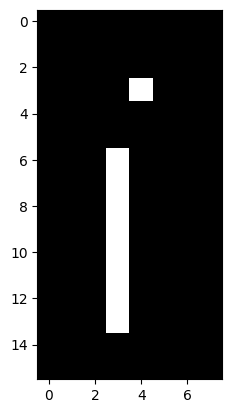

In [366]:
from torchvision.io import read_image
from torchvision.io import ImageReadMode

inp = read_image("i.jpg", mode = ImageReadMode.GRAY)
inp = inp.to(torch.float32).reshape((1,1,16,8))

inp[inp<=40.] = 1
inp[inp>40.] = 0


img = inp.squeeze()
plt.imshow(img, cmap="gray")

pred = model(inp)
pred_probab = nn.Softmax(dim=1)(pred)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

In [367]:
torch.save(model, 'model.pth')